In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import KFold

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset
train_dataset = ImageFolder(root="F:/FYP_save/dataset/colour/train/", transform=transform_train)

# Define batch size
batch_size = 32

# Number of epochs and k-fold
num_epochs = 50
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Store metrics for each fold
fold_train_losses = []
fold_train_accs = []
fold_val_losses = []
fold_val_accs = []

# Early stopping parameters
early_stopping_patience = 5

for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f'Fold [{fold + 1}/{k_folds}]')

    # Create DataLoader for current fold
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Initialize model
    model = models.googlenet(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
    model = model.to(device)  # Move model to GPU

    # Add dropout for regularization
    model.dropout = nn.Dropout(0.5)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

    # Training loop
    fold_train_loss_history = []
    fold_train_acc_history = []
    fold_val_loss_history = []
    fold_val_acc_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        fold_train_loss_history.append(train_loss)
        fold_train_acc_history.append(train_accuracy)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move data to GPU

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        fold_val_loss_history.append(val_loss)
        fold_val_acc_history.append(val_accuracy)

        scheduler.step(val_loss)

        print(f'Fold [{fold + 1}/{k_folds}], Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping!")
                break

    fold_train_losses.append(fold_train_loss_history)
    fold_train_accs.append(fold_train_acc_history)
    fold_val_losses.append(fold_val_loss_history)
    fold_val_accs.append(fold_val_acc_history)

    # Save the model after training the fold
    torch.save({
        'fold': fold,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': fold_train_loss_history,
        'train_acc': fold_train_acc_history,
        'val_loss': fold_val_loss_history,
        'val_acc': fold_val_acc_history
    }, f'googlenet_fold_{fold + 1}_epoch_{num_epochs}.pth')

# Average metrics across folds
avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_train_accs = np.mean(fold_train_accs, axis=0)
avg_val_losses = np.mean(fold_val_losses, axis=0)
avg_val_accs = np.mean(fold_val_accs, axis=0)

Fold [1/5]


c:\Users\ycloo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ycloo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ycloo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\Users\ycloo\AppD

Fold [1/5], Epoch [1/50], Train Loss: 1.0382, Train Acc: 0.6568, Val Loss: 0.9550, Val Acc: 0.7178
Fold [1/5], Epoch [2/50], Train Loss: 0.6949, Train Acc: 0.7584, Val Loss: 0.6140, Val Acc: 0.7756
Fold [1/5], Epoch [3/50], Train Loss: 0.6116, Train Acc: 0.7851, Val Loss: 0.6317, Val Acc: 0.7768
Fold [1/5], Epoch [4/50], Train Loss: 0.5693, Train Acc: 0.7987, Val Loss: 0.5801, Val Acc: 0.7915
Fold [1/5], Epoch [5/50], Train Loss: 0.5286, Train Acc: 0.8158, Val Loss: 0.5727, Val Acc: 0.8057
Fold [1/5], Epoch [6/50], Train Loss: 0.4823, Train Acc: 0.8253, Val Loss: 0.5952, Val Acc: 0.7819
Fold [1/5], Epoch [7/50], Train Loss: 0.4505, Train Acc: 0.8366, Val Loss: 0.5161, Val Acc: 0.8255
Fold [1/5], Epoch [8/50], Train Loss: 0.4137, Train Acc: 0.8508, Val Loss: 0.5636, Val Acc: 0.8108
Fold [1/5], Epoch [9/50], Train Loss: 0.3696, Train Acc: 0.8630, Val Loss: 0.5688, Val Acc: 0.8198
Fold [1/5], Epoch [10/50], Train Loss: 0.3830, Train Acc: 0.8636, Val Loss: 0.6614, Val Acc: 0.8040
Fold [1/5

c:\Users\ycloo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Fold [4/5], Epoch [1/50], Train Loss: 1.0114, Train Acc: 0.6572, Val Loss: 0.8215, Val Acc: 0.7438
Fold [4/5], Epoch [2/50], Train Loss: 0.7325, Train Acc: 0.7470, Val Loss: 0.7364, Val Acc: 0.7370
Fold [4/5], Epoch [3/50], Train Loss: 0.6371, Train Acc: 0.7745, Val Loss: 0.8628, Val Acc: 0.7012
Fold [4/5], Epoch [4/50], Train Loss: 0.5756, Train Acc: 0.7977, Val Loss: 0.6160, Val Acc: 0.7891
Fold [4/5], Epoch [5/50], Train Loss: 0.5098, Train Acc: 0.8197, Val Loss: 0.6244, Val Acc: 0.7772
Fold [4/5], Epoch [6/50], Train Loss: 0.4878, Train Acc: 0.8267, Val Loss: 0.6500, Val Acc: 0.7891
Fold [4/5], Epoch [7/50], Train Loss: 0.4597, Train Acc: 0.8296, Val Loss: 0.6770, Val Acc: 0.7806
Fold [4/5], Epoch [8/50], Train Loss: 0.4145, Train Acc: 0.8462, Val Loss: 0.6258, Val Acc: 0.8022
Fold [4/5], Epoch [9/50], Train Loss: 0.2703, Train Acc: 0.9003, Val Loss: 0.4803, Val Acc: 0.8486
Fold [4/5], Epoch [10/50], Train Loss: 0.2138, Train Acc: 0.9187, Val Loss: 0.4794, Val Acc: 0.8452
Fold [4/5

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

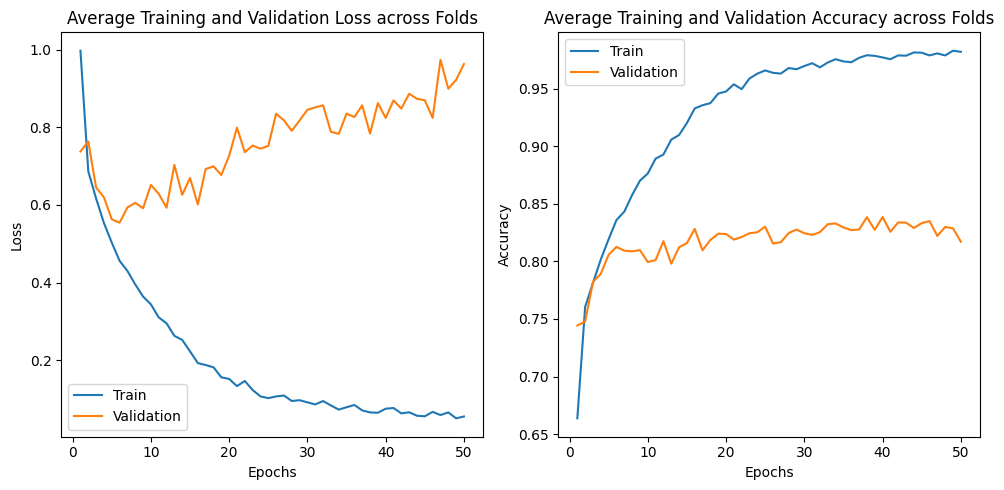

In [ ]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_train_losses, label='Train')
plt.plot(epochs, avg_val_losses, label='Validation')
plt.title('Average Training and Validation Loss across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, avg_train_accs, label='Train')
plt.plot(epochs, avg_val_accs, label='Validation')
plt.title('Average Training and Validation Accuracy across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()